# Testing ipyb for model status

notebook build based on example from [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md)

# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# Setting up environment
# This is needed to display the images.
%matplotlib inline

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

# Model preparation 

## Variables

Those variables used after creating inference graph.

In [2]:

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = 'output/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'label.pbtxt'

NUM_CLASSES = 2

detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [3]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

## Helper code

In [4]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    #im_width = 717
    #im_height = 600
    return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [15]:
# For range has to be set by number of images appeared in testing graph.
PATH_TO_TEST_IMAGES_DIR = 'test'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'st{}.jpg'.format(i)) for i in range(1, 3) ]
0
# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

print(TEST_IMAGE_PATHS)

['test/st1.jpg', 'test/st2.jpg']


{1: {'id': 1, 'name': 'elephant'}, 2: {'id': 2, 'name': 'horse'}}
0.20114851
{1: {'id': 1, 'name': 'elephant'}, 2: {'id': 2, 'name': 'horse'}}
0.06700134


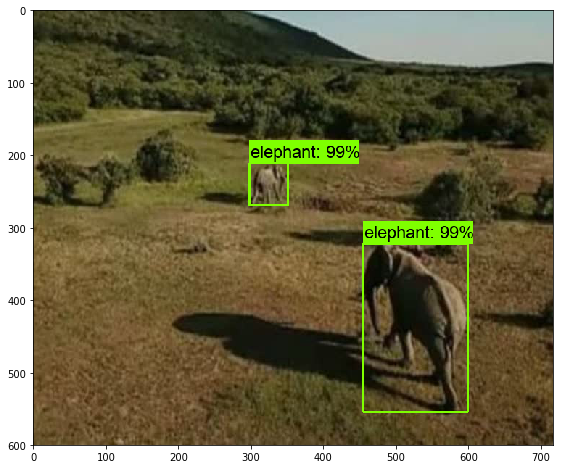

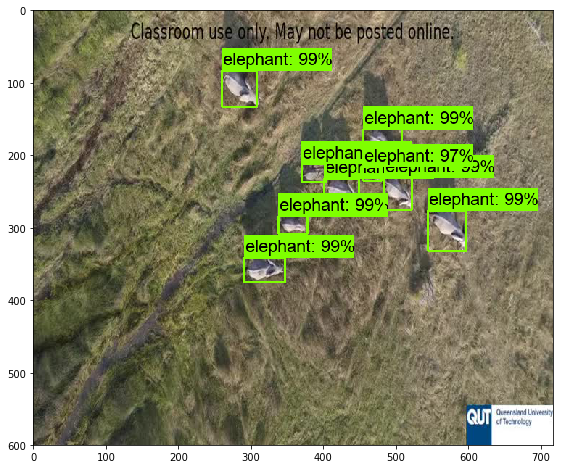

In [18]:
with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    # Definite input and output Tensors for detection_graph
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    # Each box represents a part of the image where a particular object was detected.
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    for image_path in TEST_IMAGE_PATHS:
      image = Image.open(image_path)
      # the array based representation of the image will be used later in order to prepare the
      # result image with boxes and labels on it.
      image_np = load_image_into_numpy_array(image)
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      # Actual detection.
      (boxes, scores, classes, num) = sess.run(
          [detection_boxes, detection_scores, detection_classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      # Visualization of the results of a detection.
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
          use_normalized_coordinates=True,
          min_score_thresh=.95,
          groundtruth_box_visualization_color='black',
          line_thickness=3)
      
      box = np.squeeze(boxes)
      print(category_index)
      ymin, xmin, ymax, xmax = box[1]
      print(xmax-xmin)
    
      plt.figure(figsize=IMAGE_SIZE)
      plt.imshow(image_np)

## Perform VIdeo Detection

import os, cv2
from tqdm import tqdm
#DOWNLOAD A VIDEO FROM COURSE RESOURCES AND PLACE IT IN TEST_DATA FOLDER
#UPDATE STRINGS BELOW WITH YOUR FILENAMES
video_inp = 'video/sample_elephant_31.mp4'
video_out = 'output/sample_elephant_31_predicted.mp4'

video_reader = cv2.VideoCapture(video_inp)

nb_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
#nb_frames = 200
frame_h = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_w = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))

video_writer = cv2.VideoWriter(video_out,
                               cv2.VideoWriter_fourcc(*'XVID'), 
                               50.0, 
                               (frame_w, frame_h))
with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    # Definite input and output Tensors for detection_graph
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    # Each box represents a part of the image where a particular object was detected.
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    
    image_np = load_image_into_numpy_array((range(nb_frames)))
    
    for i in tqdm(range(nb_frames)):
        ret, image = video_reader.read()

        input_image = cv2.resize(image, (716, 600))
        input_image = input_image / 255.
        input_image = input_image[:,:,::-1]
        input_image = np.expand_dims(input_image, 0)

        #netout = model.predict([input_image, dummy_array])
        
        # the array based representation of the image will be used later in order to prepare the
        # result image with boxes and labels on it.
        # image_np = load_image_into_numpy_array(input_image)
        # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
        image_np_expanded = np.expand_dims(image, axis=0)
        # Actual detection.
        (boxes, scores, classes, num) = sess.run(
            [detection_boxes, detection_scores, detection_classes, num_detections],
            feed_dict={image_tensor: image_np_expanded})
        # Visualization of the results of a detection.
        vis_util.visualize_boxes_and_labels_on_image_array(
            image_np,
            np.squeeze(boxes),
            np.squeeze(classes).astype(np.int32),
            np.squeeze(scores),
            category_index,
            use_normalized_coordinates=True,
            line_thickness=8)
        video_writer.write(np.uint8(image_np))
    video_reader.release()
    video_writer.release()